<a href="https://colab.research.google.com/github/BarchilhaMateus/Quant-Finance-Studies-/blob/main/black_scholes_option_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Black Scholes Formula is $$\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}+rS \frac{\partial V}{\partial S} - rV = 0$$

Solving the above, we know thtat the value of a call option for a non-dividend paying stock is:
$$C = SN(d_1) - Ke^{-rt}N(d_2)$$

and the corresponding put option price is
$$P = Ke{-rt}N(-d_2) - SN(d_2)$$

where
$$d_1 = \frac{1}{\sigma \sqrt{t}} \left[ln \left(\frac{S}{K} \right)+ \left(r + \frac{\sigma^2}{2} \right)t \right]

$$d2 = d1 - \sigma \sqrt{t}

$$N(x) = \frac{1}{\sqrt{2 \pi}} \int \limits_{- \infty}^{x} e^{-\frac{1}{2}x^2}dx$$

S is the spot price of the underlying asset
K is the strike price
r is the annualized continuous compounded risk free rate
\sigma is the volatility of returns of the underlying asset
t is time to maturity (expressed in years)
N(x) is the standard normal cumulative function

In [ ]:
#importing required libraries
import pandas as pd
from numpy import *
import yfinance as yf
from scipy.stats import norm

#plotting
import matplotlib.pyplot as plt
from tabulate import tabulate

#set max row to 300
pd.set_option('display.max_rows', 300)

In [ ]:
class BS:

    """
    This is a class for Options contract for pricing European options on stocks without dividends.

    Attributes:
        spot          : int or float
        strike        : int or float
        rate          : float
        dte           : int or float [days to expiration in number of years]
        volatility    : float
    """

    def __init__(self, spot, strike, rate, dte, volatility):
        self.spot = spot  # spot price
        self.strike = strike  # option strike
        self.rate = rate  # interest rate
        self.dte = dte  # days to expiration
        self.volatility = volatility  # volatility of underlying asset
        self._a_ = self.volatility * sqrt(self.dte)  # volatility * sqrt(dte)

        if self.strike == 0:
            raise ZeroDivisionError('The strike price cannot be zero')

        else:
            self._d1_ = (log(self.spot / self.strike) + \
                         (self.rate + (self.volatility ** 2) / 2) * self.dte) / self._a_

        self._d2_ = self._d1_ - self._a_
        self._b_ = e ** -(self.rate * self.dte)

        # the dict atribute
        # '''Contains all the attributes defined for the object itself. It maps the attribute name to its value.

        for i in ['Callprice', 'putprice', 'callDelta', 'putDelta', 'callTheta', 'putTheta', 'vega', 'gamma', 'callRho', 'putRho']:
            self.__dict__[i] = None
        [self.Callprice, self.putprice] = self._price()
        [self.callDelta, self.putDelta] = self._delta()
        [self.callTheta, self.putTheta] = self._theta()
        [self.callRho, self.putRho] = self._rho()
        self.vega = self._vega()
        self.gamma = self._gamma()

    def _price(self):
        """
        This method calculates the price of a call and put option.
        """
        if self.volatility == 0 or self.dte == 0:
            call = maximum(0.0, self.spot - self.strike)
            put = maximum(0.0, self.strike - self.spot)
        else:
            call = self.spot * norm.cdf(self._d1_) - self.strike * e ** (-self.rate * self.dte) * norm.cdf(self._d2_)

            put = self.strike * e ** (-self.rate * self.dte) * norm.cdf(-self._d2_) - self.spot * norm.cdf(-self._d1_)

        return [call, put]

    def _delta(self):
        """
        This method calculates the delta of a call and put option.
        """
        if self.volatility == 0 or self.dte == 0:
            callDelta = 1.0 if self.spot > self.strike else 0.0
            putDelta = -1.0 if self.spot < self.strike else 0.0
        else:
            callDelta = norm.cdf(self._d1_)
            putDelta = -norm.cdf(-self._d1_)
        return [callDelta, putDelta]

    # Option vegas
    def _vega(self):
        """
        This method calculates the vega of a call and put option.
        """
        if self.volatility == 0 or self.dte == 0:
            vega = 0.0
        else:
            vega = self.spot * norm.pdf(self._d1_) * sqrt(self.dte) / 100
        return vega

    # Option Theta
    def _theta(self):
        """
        This method calculates the theta of a call and put option.
        """

        callTheta = -self.spot * norm.pdf(self._d1_) * self.volatility / (2 * sqrt(self.dte)) - self.rate * self.strike * self._b_ * norm.cdf(self._d2_) / 365
        putTheta = -self.spot * norm.pdf(self._d1_) * self.volatility / (2 * sqrt(self.dte)) + self.rate * self.strike * self._b_ * norm.cdf(-self._d2_) / 365
        return [callTheta, putTheta]

    # Option Rho
    def _rho(self):
        """
        This method calculates the rho of a call and put option.
        """
        callRho = self.strike * self.dte * self._b_ * norm.cdf(self._d2_) / 100
        putRho = -self.strike * self.dte * self._b_ * norm.cdf(-self._d2_) / 100
        return [callRho, putRho]

    # Option Gamma
    def _gamma(self):
        """
        This method calculates the gamma of a call and put option.
        """
        if self.volatility == 0 or self.dte == 0:
            gamma = 0.0
        else:
            gamma = norm.pdf(self._d1_) / (self.spot * self._a_)
        return gamma


# initialize option
option = BS(100, 100, 0.05, 0.5, 0.2)

header = ['Option Price', 'Delta', 'Theta', 'Vega', 'Gamma', 'Rho']
table = [[option.Callprice, option.callDelta, option.callTheta, option.vega, option.gamma, option.callRho]]

print(tabulate(table, headers=header, tablefmt='fancy_grid'))


╒════════════════╤══════════╤══════════╤══════════╤═══════════╤══════════╕
│   Option Price │    Delta │    Theta │     Vega │     Gamma │      Rho │
╞════════════════╪══════════╪══════════╪══════════╪═══════════╪══════════╡
│        6.88873 │ 0.597734 │ -5.47898 │ 0.273587 │ 0.0273587 │ 0.264424 │
╘════════════════╧══════════╧══════════╧══════════╧═══════════╧══════════╛


VALE OPTION

In [ ]:
aple = yf.Ticker('AAPL')
options = aple.option_chain('2023-05-05')

In [ ]:
from datetime import datetime
(datetime(2023, 5, 5) - datetime.now()).days / 365

0.0821917808219178

In [ ]:
#may 2023 400 apple call option price
spot = 400; strike = 400; rate = 0.0; dte = 0.575; volatility = 0.1805

aple_opt = BS(spot, strike, rate, dte, volatility)
print(f'Option price of AAPL 400 call option is {aple_opt.Callprice}')

Option price of AAPL 400 call option is 21.8243991019678


In [ ]:
options.calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL230505C00050000,2023-03-27 17:16:07+00:00,50.0,108.27,115.60,116.1,0.0,0.0,NaN,1,1.851563,True,REGULAR,USD
1,AAPL230505C00095000,2023-03-29 19:37:30+00:00,95.0,66.34,70.80,71.3,0.0,0.0,NaN,1,1.010747,True,REGULAR,USD
2,AAPL230505C00120000,2023-04-03 14:50:13+00:00,120.0,45.52,46.00,46.5,0.0,0.0,1.0,3,0.682620,True,REGULAR,USD
3,AAPL230505C00125000,2023-03-28 16:53:56+00:00,125.0,32.60,41.05,41.6,0.0,0.0,NaN,1,0.625736,True,REGULAR,USD
4,AAPL230505C00130000,2023-03-31 13:31:31+00:00,130.0,33.45,36.15,36.7,0.0,0.0,2.0,4,0.571782,True,REGULAR,USD


In [ ]:
#filters calls for a strike at or above 100
DF = options.calls[options.calls['strike'] >= 100]
DF.reset_index(drop=True, inplace=True)

#dataframe manipulation with selected fields
DF = pd.DataFrame({'strike': DF['strike'], 'lastPrice': DF['lastPrice'], 'volume': DF['volume'], 'impliedVolatility': DF['impliedVolatility']})

#derive greeks and assign to dataframe as columns
DF['Delta'] = DF['Gamma'] = DF['Theta'] = DF['Vega'] = DF['Rho'] = 0.0

for i in range(len(DF)):

    DF['Delta'].iloc[i] = BS(spot, DF['strike'].iloc[i], rate, dte, DF['impliedVolatility'].iloc[i]).callDelta
    DF['Gamma'].iloc[i] = BS(spot, DF['strike'].iloc[i], rate, dte, DF['impliedVolatility'].iloc[i]).gamma
    DF['Theta'].iloc[i] = BS(spot, DF['strike'].iloc[i], rate, dte, DF['impliedVolatility'].iloc[i]).callTheta
    DF['Vega'].iloc[i] = BS(spot, DF['strike'].iloc[i], rate, dte, DF['impliedVolatility'].iloc[i]).vega


DF.head()

,strike,lastPrice,volume,impliedVolatility,Delta,Gamma,Theta,Vega,Rho
0,120.0,45.52,1.0,0.682620,0.995128,0.000068,-2.543945,0.042857,0.0
1,125.0,32.60,NaN,0.625736,0.996413,0.000057,-1.773389,0.032592,0.0
2,130.0,33.45,2.0,0.571782,0.997515,0.000044,-1.163876,0.023409,0.0
3,135.0,31.33,3.0,0.519048,0.998444,0.000032,-0.690621,0.015301,0.0
4,139.0,27.56,1.0,0.510259,0.998279,0.000036,-0.744306,0.016775,0.0


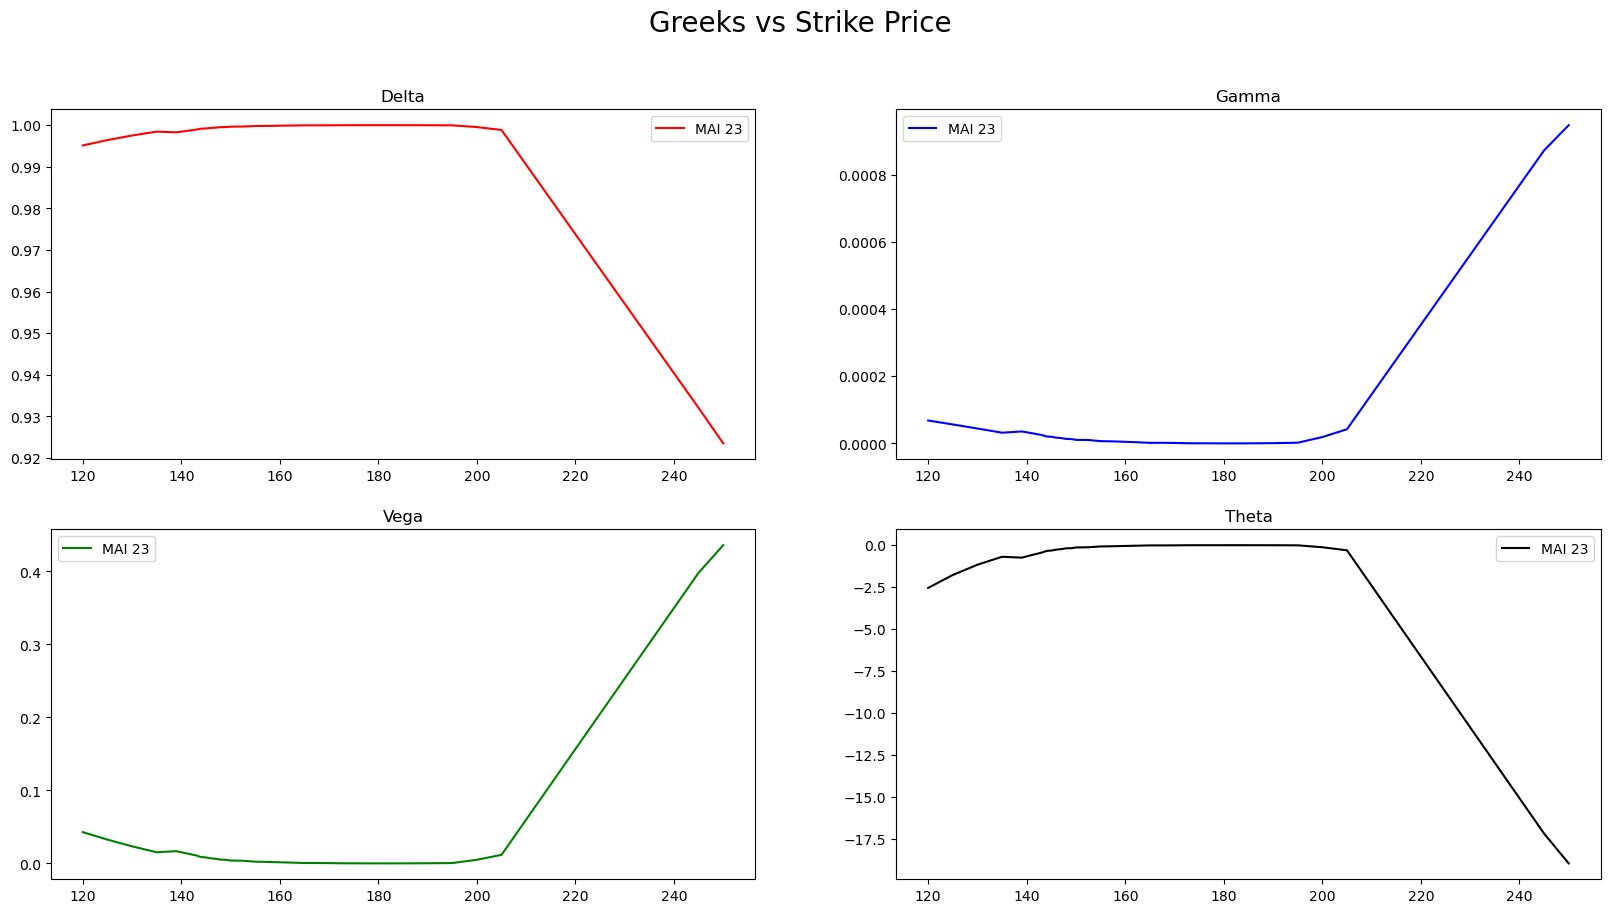

In [ ]:
#plot graph

fig, ax = plt.subplots(2,2,figsize = (20,10))

ax[0,0].plot(DF['strike'], DF['Delta'], color = 'red', label = 'MAI 23')
ax[0,1].plot(DF['strike'], DF['Gamma'], color = 'blue', label = 'MAI 23')
ax[1,0].plot(DF['strike'], DF['Vega'], color = 'green', label = 'MAI 23')
ax[1,1].plot(DF['strike'], DF['Theta'], color = 'black', label = 'MAI 23')

#set axis title
ax[0,0].set_title('Delta'), ax[0,1].set_title('Gamma'), ax[1,0].set_title('Vega'), ax[1,1].set_title('Theta')

#define legend
ax[0,0].legend(), ax[0,1].legend(), ax[1,0].legend(), ax[1,1].legend()

#set title
fig.suptitle('Greeks vs Strike Price', fontsize = 20)

plt.show()